## Model Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
from itertools import permutations
from itertools import combinations
from pyEDM import *
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
import time
import os
from copy import deepcopy
import math
import random
from sklearn.metrics import root_mean_squared_error
from scipy.stats import ttest_ind
import pickle
import ast
import json



from IPython.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))

import warnings
warnings.filterwarnings("ignore", 
    message="A worker stopped while some jobs were given to the executor.",
    module="joblib.externals.loky.process_executor")

In [2]:
data_path = "Data/orig_block.csv"
model_path = "deyle_models2.csv"


In [3]:
def str_to_list(s):
    s = s.replace('nan', 'null')  # Replace 'nan' with 'null' for JSON compatibility
    lst = json.loads(s)  # Convert string to list
    lst = [np.nan if x is None else x for x in lst]  # Replace None with np.nan
    return lst

def process_parameters(path):

    parameters = pd.read_csv(path) 
    parameters['pred'] = parameters['pred'].apply(str_to_list)
    parameters['columns'] = parameters['columns'].apply(ast.literal_eval)
    parameters.sort_values(by='rho',ascending=False)
    return parameters

def clean_data(data_path):
    paper_data = pd.read_csv(data_path)
    # paper_data = paper_data.set_index('time')
    paper_data['Time'] = paper_data.index.astype(int)
    cols_to_drop = [col for col in paper_data.columns if 
                '1wk' in col or
                '_2wk' in col]
    paper_data = paper_data.drop(columns=cols_to_drop)
    # paper_data['Avg_Chloro'] #= paper_data['Avg_Chloro'].apply(np.log1p) #LOG AMPUTATION
    #IMPUTE HAB DATA
    #Build basic linear regression model as sanity check
    # Custom impute missing values with the average of the value in front and behind of it 
    class ForwardBackwardImputer(BaseEstimator, TransformerMixin):
        def __init__(self):
            pass

        def fit(self, X, y=None):
            return self

        def transform(self, X):
            X_filled_forward = X.fillna(method='ffill').fillna(method='bfill')
            X_filled_backward = X.fillna(method='bfill').fillna(method='ffill')

            return (X_filled_forward + X_filled_backward) / 2


    Imputer = ForwardBackwardImputer()
    paper_data = paper_data.apply(pd.to_numeric, errors='coerce')
    Imputer.fit(paper_data)
    # paper_data = Imputer.transform(paper_data)#COMMENT OUT IF DONT WANT MEAN MPUTE
    return paper_data

In [4]:

data = clean_data(data_path)
parameters = process_parameters(model_path)
target = 'chlA'#'Lingulodinium_polyedra'
parameters

,Unnamed: 0,target,columns,E,theta,rho,rmse,pred
0,0,chlA,"[chlA(t-6), nitrite(t-5), phosphate(t-3)]",3,1,0.266969,4.053932,"[nan, 2.866443332378858, 4.5700028853753265, 2..."
1,1,chlA,"[SST(t-4), U_WIND(t-5), WIND_SPD(t-2)]",3,1,0.258937,4.086273,"[nan, 3.9509083747986646, 3.3552722978486655, ..."
2,2,chlA,"[SST(t-2), nitrate(t-5), nitrite(t-2)]",3,1,0.271649,4.071881,"[nan, 4.3272548422363215, 3.6779509901933145, ..."
3,3,chlA,"[nitrate(t-4), phosphate(t-5), phosphate(t-6)]",3,1,0.245255,4.087891,"[nan, 2.912740336433207, 2.5209794268176466, 3..."
4,4,chlA,"[chlA(t-2), nitrate(t-4), phosphate(t-4)]",3,1,0.286682,4.080833,"[nan, 2.6719379137308055, 3.092025826398066, 2..."
...,...,...,...,...,...,...,...,...
27911,27911,chlA,"[N_star(t-3), U_WIND(t-4), WIND_SPD(t-1), chlA...",7,45,0.027706,44.088806,"[nan, 2.249084320081348, -246.05038624053535, ..."
27912,27912,chlA,"[WIND_SPD(t-1), WIND_SPD(t-4), WIND_SPD(t-5), ...",7,45,0.021804,30.160609,"[nan, 4.281252552758566, 3.0673288603922937, -..."
27913,27913,chlA,"[N_star(t-1), SST(t-3), U_WIND(t-4), WIND_SPD(...",7,45,0.018652,25.422602,"[nan, 2.356849898208229, 4.3171918364896475, 4..."
27914,27914,chlA,"[N_star(t-4), U_WIND(t-5), WIND_SPD(t-6), chlA...",7,45,0.019367,19.413878,"[nan, 7.580153579617841, 4.687557558340828, 1...."


In the 90 percentile there are 2791 models


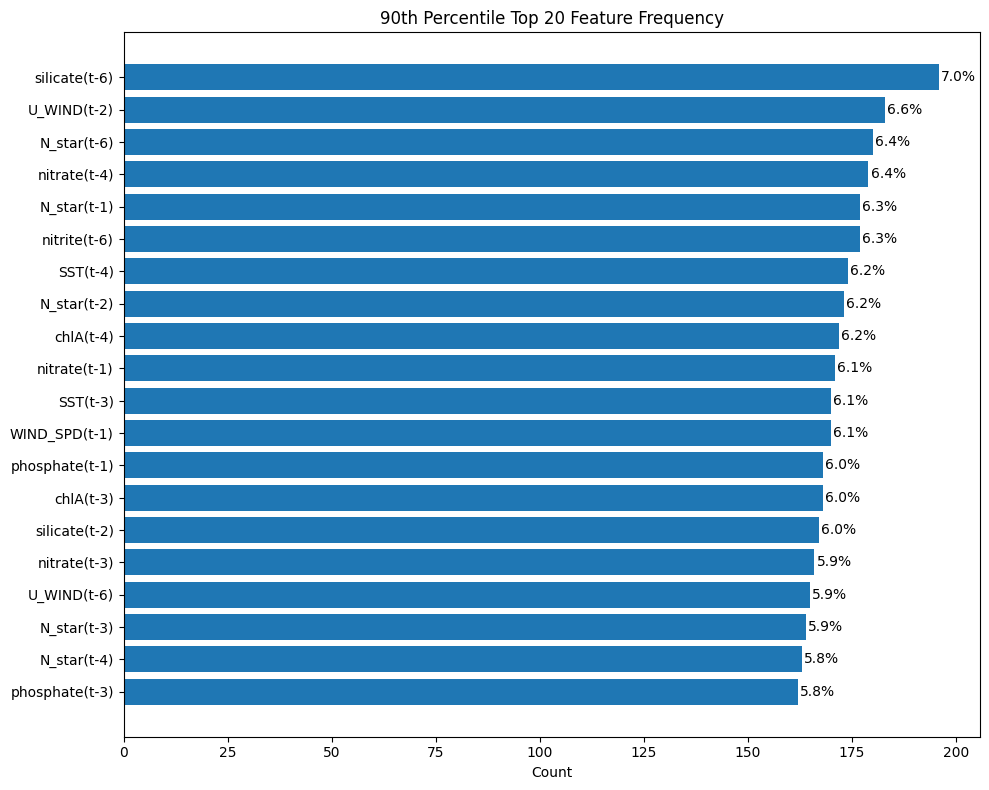

In [8]:
import matplotlib.pyplot as plt

def visualize_common_lags(parameters, percentile, top_n=15):
    # Count how many models are in the given percentile
    parameters.sort_values(by='rho',ascending=False)
    num_models = int(parameters.shape[0] * (1 - (percentile / 100)))
    print(f'In the {percentile} percentile there are {num_models} models')

    # Tally up all the lags
    param_cnts = {}
    for i in range(num_models):
        for col in parameters['columns'].iloc[i]:
            #if col == f'{target}(t-0)':
             #   continue
            param_cnts[col] = param_cnts.get(col, 0) + 1

    # Sort and keep only the top_n items
    sorted_items = sorted(param_cnts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    if not sorted_items:
        print("No parameters to display.")
        return

    features, counts = zip(*sorted_items)

    # Plot
    plt.figure(figsize=(10, 8))
    bars = plt.barh(features, counts)
    plt.xlabel("Count")
    plt.title(f"{percentile}th Percentile Top {top_n} Feature Frequency")
    plt.gca().invert_yaxis()

    # Annotate percentages
    for bar, count in zip(bars, counts):
        pct = (count / num_models) * 100
        plt.text(bar.get_width() + 0.5,
                 bar.get_y() + bar.get_height()/2,
                 f'{pct:.1f}%',
                 va='center')

    plt.tight_layout()
    plt.show()


# Call it:
visualize_common_lags(parameters, 90, top_n=20)


In [9]:
#Make prediction based on if p% of n models predict bloom
def eval_ensemble(obs_blooms, pred_blooms):
    Accuracy = 1 - (obs_blooms ^ pred_blooms).mean()
    True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
    False_pos = ((~obs_blooms) & pred_blooms).sum() / (~obs_blooms).sum()
    True_neg = ((~obs_blooms) & (~pred_blooms)).sum() / (~obs_blooms).sum()
    False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()
    
    return [Accuracy, True_pos, False_pos, True_neg, False_neg]
    

'''
Inputs:
p -> val less than 1 which represents proportions of models which must predict bloom (aka the sensitivity)
n -> from n top models
samp -> num from n*samp top models
outputs -> array of trues and falses of blooms
'''
def ensemble_binary_bloom(parameters_df,n=100,p=0.1,samp=1,bloom_thresh=np.percentile(data[target],95)):
    parameters_df = parameters_df.sort_values(by='rho',ascending=False)
    parameters_df = parameters_df.iloc[0:n*samp:samp]#.sample(n)
    sum = np.zeros(np.array(parameters_df['pred'].iloc[0][1:-1]).size)
    for i in range(n):
        curr = np.array(parameters_df['pred'].iloc[i][1:-1]) > bloom_thresh#np.percentile(parameters_df['pred'].iloc[i].iloc[1:],95)#
        sum = sum + curr
    return sum > (n*p), sum



Bloom threshold is 6.737999999999997
613
In the eval set there is 62 blooms


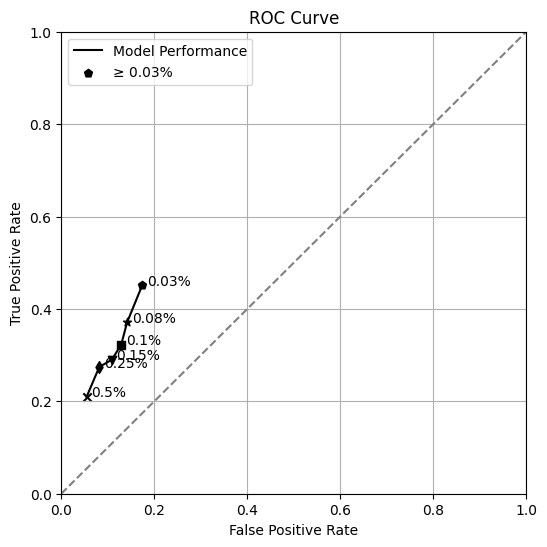

In [10]:
#plot ROC for various sensitivities
bloom_thresh = np.percentile(data[target].iloc[:1012],95)
print(f'Bloom threshold is {bloom_thresh}')
results, _ = ensemble_binary_bloom(parameters,samp=1,p=0.1,bloom_thresh=bloom_thresh,n=3)
observations = data[target].iloc[-1*len(results):] > bloom_thresh
print(len(observations))
print(f'In the eval set there is {sum(observations)} blooms')
p_list = [0.03,0.08,0.1,0.15,0.25,0.5]
samp = 2
num_models = 1000
TP_list = []
FP_list = []
for p in p_list:
    results, _ = ensemble_binary_bloom(parameters,samp=samp,p=p,bloom_thresh=bloom_thresh,n=num_models)
    eval = eval_ensemble(observations, results)
    TP_list.append(eval[1])
    FP_list.append(eval[2])

markers = ['p', '*', 's', 'v', 'd', 'x']  
plt.figure(figsize=(6,6))
plt.plot(FP_list, TP_list, linestyle='-', color='black', marker='None', label="Model Performance")

for i, (fp, tp, p, marker) in enumerate(zip(FP_list, TP_list, p_list, markers)):
    plt.scatter(fp, tp, marker=marker, color='black', label=f"≥ {p}%" if i == 0 else "")
    plt.text(fp + 0.01, tp, f"{p}%", fontsize=10)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.title("ROC Curve")
plt.show()

In [11]:
val1, val2 = ensemble_binary_bloom(parameters,samp=samp,p=0.2,bloom_thresh=bloom_thresh,n=num_models)

len(val2)

613

In [12]:
parameters[parameters['theta'] > 5]

,Unnamed: 0,target,columns,E,theta,rho,rmse,pred
1578,1578,chlA,"[chlA(t-6), nitrite(t-5), phosphate(t-3)]",3,9,0.121673,6.872810,"[nan, 2.4304511116610064, 26.619964123579862, ..."
1579,1579,chlA,"[SST(t-4), U_WIND(t-5), WIND_SPD(t-2)]",3,9,0.002154,6.062995,"[nan, 1.9555333252996643, 2.046214307321091, 3..."
1580,1580,chlA,"[SST(t-2), nitrate(t-5), nitrite(t-2)]",3,9,0.049415,5.352719,"[nan, 2.682179381305266, 3.824405521976295, 2...."
1581,1581,chlA,"[nitrate(t-4), phosphate(t-5), phosphate(t-6)]",3,9,0.146034,6.168331,"[nan, 2.9572746303555126, 2.9373657967047997, ..."
1582,1582,chlA,"[chlA(t-2), nitrate(t-4), phosphate(t-4)]",3,9,0.129988,6.902113,"[nan, 2.215068888992481, 2.9741161390484985, 3..."
...,...,...,...,...,...,...,...,...
27911,27911,chlA,"[N_star(t-3), U_WIND(t-4), WIND_SPD(t-1), chlA...",7,45,0.027706,44.088806,"[nan, 2.249084320081348, -246.05038624053535, ..."
27912,27912,chlA,"[WIND_SPD(t-1), WIND_SPD(t-4), WIND_SPD(t-5), ...",7,45,0.021804,30.160609,"[nan, 4.281252552758566, 3.0673288603922937, -..."
27913,27913,chlA,"[N_star(t-1), SST(t-3), U_WIND(t-4), WIND_SPD(...",7,45,0.018652,25.422602,"[nan, 2.356849898208229, 4.3171918364896475, 4..."
27914,27914,chlA,"[N_star(t-4), U_WIND(t-5), WIND_SPD(t-6), chlA...",7,45,0.019367,19.413878,"[nan, 7.580153579617841, 4.687557558340828, 1...."


In [13]:
parameters.sort_values(by='rho',ascending=False)['pred'].iloc[0][1:-1]

[3.1641690325617713,
 3.3043365256555175,
 3.0911482743226992,
 3.6989460280992095,
 3.550637803333806,
 3.784454753289795,
 6.474120269174152,
 6.044635699187874,
 6.940969505116579,
 6.280895198216669,
 4.597636770684255,
 8.866411063412164,
 6.7452477543553035,
 4.143410186565047,
 3.974719665224015,
 3.793930452997028,
 3.375084696804852,
 8.829203185661779,
 7.11715622574989,
 7.103602280987825,
 6.042763908497028,
 6.913474316785649,
 6.326105917096947,
 3.1340969576099287,
 2.916495849441814,
 3.7423201492023654,
 4.26947379454487,
 4.188510919918929,
 4.357162897897091,
 3.909813204283966,
 2.6133278345679587,
 3.681669758774316,
 8.680733717903873,
 7.588253524943537,
 7.9514236594747425,
 7.179055042033932,
 4.2016911103923835,
 3.503371814252525,
 5.019750355439051,
 6.697270231091133,
 10.252856803644548,
 7.522244318356689,
 5.733169539112618,
 3.01043669187076,
 5.828031338172221,
 5.732192169266091,
 7.870616458856476,
 6.921413136944449,
 5.305604675351748,
 2.680112005

In [14]:
parameters.sort_values(by='rho',ascending=False)

,Unnamed: 0,target,columns,E,theta,rho,rmse,pred
22680,22680,chlA,"[N_star(t-6), WIND_SPD(t-1), chlA(t-2), nitrat...",7,1,0.321867,3.994489,"[nan, 3.1641690325617713, 3.3043365256555175, ..."
1440,1440,chlA,"[U_WIND(t-6), chlA(t-2), nitrate(t-3)]",3,5,0.320627,4.270173,"[nan, 2.3805481209045936, 2.5858180062140654, ..."
22672,22672,chlA,"[U_WIND(t-1), WIND_SPD(t-1), WIND_SPD(t-5), ch...",7,1,0.317644,4.017457,"[nan, 3.2422515058569106, 3.5197740837336644, ..."
22784,22784,chlA,"[U_WIND(t-5), WIND_SPD(t-6), chlA(t-2), nitrit...",7,1,0.314076,4.015841,"[nan, 3.0868962105052518, 3.0129937124058994, ..."
5540,5540,chlA,"[N_star(t-5), chlA(t-2), nitrate(t-1), phospha...",4,1,0.313151,4.033397,"[nan, 2.683767456301858, 3.0673109382180876, 2..."
...,...,...,...,...,...,...,...,...
26943,26943,chlA,"[N_star(t-2), SST(t-1), chlA(t-3), nitrate(t-5...",7,35,-0.244451,50.722153,"[nan, 2.493788014993705, 1.4314030994923321, -..."
27379,27379,chlA,"[SST(t-1), chlA(t-3), chlA(t-6), nitrate(t-1),...",7,45,-0.251956,39.241670,"[nan, 2.2040943616746294, -4.150888027746596, ..."
21620,21620,chlA,"[SST(t-2), U_WIND(t-6), WIND_SPD(t-5), chlA(t-...",6,45,-0.258559,35.827725,"[nan, 3.2139342735124963, 4.754489058612583, 9..."
25779,25779,chlA,"[SST(t-1), chlA(t-3), chlA(t-6), nitrate(t-1),...",7,25,-0.265496,26.690225,"[nan, 2.1974269072526607, 0.1129309041292772, ..."


In [15]:
 np.percentile(data[target].iloc[:1012],98)

np.float64(13.621399999999996)